In [1]:
from matplotlib import pyplot
from atmos_cloud_sim_uj_utils import show_plot
from PySDM.physics import constants as const
from PySDM import Formulae
from PySDM_examples.UIUC_2021.curved_text import CurvedText
from PySDM_examples.UIUC_2021.commons import FREEZING_CONSTANTS, COOLING_RATES, TEMP_RANGE
import numpy as np
import pint
si = pint.UnitRegistry()
si.setup_matplotlib()

/home/slayoo/devel/PySDM/PySDM/backends/__init__.py:32: UserWarning: CUDA library found but cuInit() failed (error code: 999; message: unknown error)
  warnings.warn(


In [2]:
params = {
    'illite': {
        'm': FREEZING_CONSTANTS['illite']['ABIFM_M'],
        'c': FREEZING_CONSTANTS['illite']['ABIFM_C'],
        'color': 'olive'
    },
    'dust': {
        'm': FREEZING_CONSTANTS['dust']['ABIFM_M'],
        'c': FREEZING_CONSTANTS['dust']['ABIFM_C'],
        'color': 'crimson'
    }
}

In [3]:
svp = Formulae(saturation_vapour_pressure='FlatauWalkoCotton').saturation_vapour_pressure
T = np.linspace(*TEMP_RANGE) * si.K

def _T(T):
    return (T/si.K).to_base_units().magnitude

a_w_ice = svp.ice_Celsius(_T(T) - const.T0) / svp.pvs_Celsius(_T(T) - const.T0)

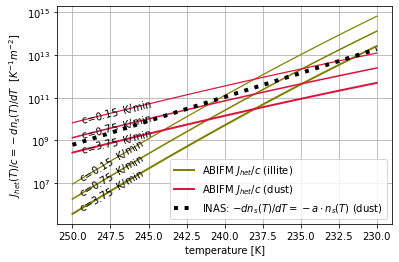

HTML(value="<a href='./INAS_vs_ABIFM.pdf' target='_blank'>./INAS_vs_ABIFM.pdf</a><br>")

In [4]:
cooling_rates = tuple((x*si.K/si.s).to_base_units() for x in COOLING_RATES)

for label, mc in params.items():
    formulae_abifm = Formulae(
        constants={
            'ABIFM_M': mc['m'],
            'ABIFM_C': mc['c']
        },
        heterogeneous_ice_nucleation_rate='ABIFM'
    )
    abifm_j_het = lambda T, formulae=formulae_abifm: (
        formulae.heterogeneous_ice_nucleation_rate.j_het(_T(T)) / si.m**2 / si.s
    )
    for i, c in enumerate(cooling_rates):
        c_K_min = (c / si.K * si.min).to_base_units().magnitude
        J_over_c = abifm_j_het(a_w_ice) / c
        pyplot.plot(T, J_over_c,
                    color=mc['color'],
                    label='' if i!=0 else f'ABIFM $J_{{het}}/c$ ({label})',
                    linewidth=3*c.magnitude**.15
                   )
        _ = CurvedText(T.magnitude, J_over_c.magnitude,
                       text=f'c={c_K_min} K/min', axes=pyplot.gca(),
                       va='bottom'
                      )
        
formulae = Formulae(
    constants=FREEZING_CONSTANTS["dust"],
    freezing_temperature_spectrum='Niemand_et_al_2012'
)
inas_ns = lambda T: formulae.freezing_temperature_spectrum.ns(_T(T)) / si.m**2

a = formulae.constants.NIEMAND_A / si.K
pyplot.plot(T, -a*inas_ns(T), label=r'INAS: $-dn_{s}(T)/dT=-a \cdot n_s(T)$ (dust)',
            color='black', linestyle=':', linewidth=4)

pyplot.gca().invert_xaxis()
pyplot.yscale('log')
pyplot.grid()
pyplot.xlabel('temperature [K]')
pyplot.ylabel('$J_{het}(T) / c = -dn_s(T)/dT$  [$K^{-1} m^{-2}$]')
pyplot.legend()#bbox_to_anchor=(1, -.2))
show_plot('INAS_vs_ABIFM.pdf')